<a href="https://colab.research.google.com/github/abuhurera8320/Automated_Eda_techniques/blob/main/Roman_Urdu_Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Conv1D,LSTM,Dense,Embedding,RepeatVector,TimeDistributed,Bidirectional,GRU,SimpleRNN
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Markdown, display
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [3]:
df=pd.read_csv('/content/drive/MyDrive/FYP /task_1_train.tsv', sep='\t')

In [4]:
df.columns=['Text','Label']
df.count()

Text     7208
Label    7208
dtype: int64

In [5]:
l=df['Label'].unique()
l_dict={0:'Abusive/Offensive',1:'Normal'}
for i in l:
    print('Label {} is for {}'.format(i,l_dict[i]))

Label 0 is for Abusive/Offensive
Label 1 is for Normal


In [6]:
offensivedf=df.loc[df['Label']==1]
offensivedf.count()

Text     3850
Label    3850
dtype: int64

In [7]:
df1=pd.read_csv('/content/drive/MyDrive/FYP /task_1_test.tsv', sep='\t')

In [8]:
df1.columns=['Text','Label']
df1.count()

Text     2002
Label    2002
dtype: int64

In [9]:
offensivedf=df1.loc[df1['Label']==1]
offensivedf.count()

Text     1069
Label    1069
dtype: int64

In [10]:
Neutral=df.loc[df['Label']==1]
Neutral.head()

,Text,Label
6,hum kisi se km nhi,1
7,aurat bhatak sakri hy kbi “maa” ni bhatakti . ...,1
10,with due respect sir kya aurat march se ye ch...,1
15,😂😂😂😂😂😂 chal ja tujhy maaf kia,1
16,agr ap chahtay hn k log ap ko acha kahean to a...,1


In [11]:
hate=df.loc[df['Label']==0]
hate.head()

,Text,Label
0,bhaunk bhaunk ke pagal ho jaata ab tak....,0
1,shivsaina nam mulla saina rakh hijra uddh...,0
2,there are some yahodi daboo like imran chore z...,0
3,"chutiye ye hunduism ni he islam he , isme koi ...",0
4,han g rakhail e awal kiya bak rai hai. kisay a...,0


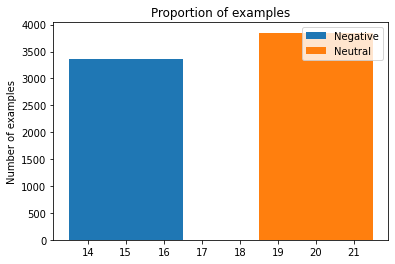

In [12]:
Neu = df[df['Label'] == 1].shape[0]
Neg = df[df['Label'] == 0].shape[0]
# bar plot of the 3 classes
plt.bar(15,Neg,3, label="Negative")
plt.bar(20,Neu,3, label="Neutral")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

## Data Preprocessing
#### 1. Removing Punctuations
#### 2. Converting to Lower case
#### 3. Removing stopwords

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
import re
def remove_punct(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and check the characters if it
    contains any puntuation and then remove them with blank space'''  
    text  = "".join([char for [char] in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


In [15]:
# removing all the punctuation
df['Text'] = df['Text'].apply(lambda x: remove_punct(str(x))) 

In [16]:
df['Text'].head()

0               bhaunk bhaunk ke pagal ho jaata ab tak
1    shivsaina  nam mulla  saina  rakh  hijra  uddh...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni he islam he  isme koi k...
4    han g rakhail e awal kiya bak rai hai kisay ah...
Name: Text, dtype: object

#### Converting the text corpus to Lower Case

In [17]:
def convert_to_lower_case(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and converts the characters  into lower case and joins them further'''
    text  = "".join([char.lower() for [char] in text if char not in string.punctuation])
    return text


In [18]:
df['Text'] = df['Text'].apply(lambda x: convert_to_lower_case(str(x))) #calling lower case on each line

In [19]:
df['Text'].head()

0               bhaunk bhaunk ke pagal ho jaata ab tak
1    shivsaina  nam mulla  saina  rakh  hijra  uddh...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni he islam he  isme koi k...
4    han g rakhail e awal kiya bak rai hai kisay ah...
Name: Text, dtype: object

### Removing Stopwords

In [20]:
stopwords=['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 'woh', 'bhi', 'aur', 'wo', 'yeh', 'rha', 
           'hota', 'ho', 'ga', 'ka', 'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya', 'gaya', 'kch',
           'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to','is', 'hi', 'jo', 'kya', 'thi', 'se', 'pe', 'phr', 'wala',
           'waisay', 'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski', 'ne', 'haan', 'acha', 'nai',
           'sent', 'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye', 'ya', 'dono', 'hoa', 'aese', 'de', 'wohi',
           'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 'gi', 'hova', 'yehi', 'jana', 'jye', 'chal', 'mil',
           'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain', 'krny', 'tou','h','je','or','jee','he','in','un','kay','ki','ya','ap','meri','me']


In [21]:
dictStopWords = {} # global variable
forFastTextData = []
def removeStopWordss(text):
    text = re.sub('[^a-zA-Z]',' ',str(text))
    text = text.lower()
    wordList =str(text).split()
    for word in wordList:
        if word in stopwords:
            wordList.remove(word)
            if word not in dictStopWords:
                dictStopWords[word]= 1
            else:
                dictStopWords[word] = dictStopWords[word] + 1
    newSentence = " ".join(wordList)
    forFastTextData.append(newSentence.split())
    return (newSentence)

In [22]:
df['Text'] = df['Text'].apply(lambda x: removeStopWordss(x)) # sentence with removed stop words

In [23]:
## checking for most common stopwords from the dictionary
import collections
from collections import Counter
dictGraph = {}
d = Counter(dictStopWords) # creating a counter 
d.most_common(10) 
for k,v in d.most_common(10):
    dictGraph[k] = v
dictGraph

{'hai': 1911,
 'hain': 607,
 'ho': 919,
 'ka': 1174,
 'ki': 1711,
 'ko': 1438,
 'me': 577,
 'na': 552,
 'se': 860,
 'to': 1040}

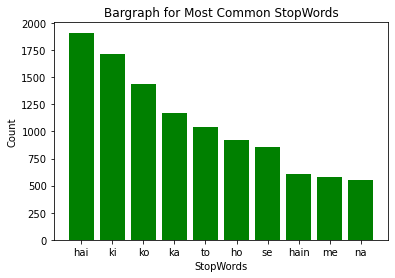

In [24]:
#plotting a graph of 10 most common stopwords from dictionary
plt.bar(dictGraph.keys(), dictGraph.values(), align='center', color = 'green')
plt.title('Bargraph for Most Common StopWords')
plt.xlabel('StopWords')
plt.ylabel('Count')
plt.show()

In [25]:
sum(dictGraph.values())

10789

In [27]:
df.to_csv('/content/drive/MyDrive/FYP /preprocessed_df.csv')

### Removal of Characters(Stemming)

In [ ]:
def replacing_characters(word):
    ''' Input Parameter: 
    word: word from the sentences'''
 
    word = re.sub(r'ain$', r'ein', word)
    word = re.sub(r'ai', r'ae', word)
    word = re.sub(r'ay$', r'e', word)
    word = re.sub(r'ey$', r'e', word)
    word = re.sub(r'aa+', r'aa', word)
    word = re.sub(r'e+', r'ee', word)
    word = re.sub(r'ai', r'ahi', word) # e.g "sahi and sai nahi"
    word = re.sub(r'ai', r'ahi', word)
    word = re.sub(r'ie$', r'y', word)
    word = re.sub(r'^es', r'is', word)
    word = re.sub(r'a+', r'a', word)
    word = re.sub(r'j+', r'j', word)
    word = re.sub(r'd+', r'd', word)
    word = re.sub(r'u', r'o', word)
    word = re.sub(r'o+', r'o', word)
    if not re.match(r'ar', word):
        word = re.sub(r'ar', r'r', word)
        word = re.sub(r'iy+', r'i', word)
        word = re.sub(r'ih+', r'eh', word)
        word = re.sub(r's+', r's', word)
    if re.search(r'[rst]y', 'word') and word[-1] != 'y':
        word = re.sub(r'y', r'i', word)
    if re.search(r'[^a]i', word):
        word = re.sub(r'i$', r'y', word)
    if re.search(r'[a-z]h', word):
        word = re.sub(r'h', '', word)
    return word

In [ ]:
df['Text'] = df['Text'].apply(lambda x: replacing_characters(x))

In [36]:
df=pd.read_csv('/content/drive/MyDrive/FYP /preprocessed_df.csv')


In [37]:
df['Text'].head()

0                     bhaunk bhaunk ke pagal jaata tak
1    shivsaina nam mulla saina rakh hijra uddhav th...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni islam isme kisi muslim ...
4    g rakhail e awal kiya bak rai kisay ahmaq kah ...
Name: Text, dtype: object

**Tokenization and Test Train Split**

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X=df['Text']
y=df['Label']


In [40]:
count = df['Text'].str.split().apply(len)
count=count.sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
MAX_SEQUENCE_LENGTH=count.iloc[0]+10
MAX_SEQUENCE_LENGTH

66

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 18664


In [42]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)

In [43]:

X_train = pad_sequences((tokenizer.texts_to_sequences(X_train)),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                      maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (5406, 66)
Testing X Shape: (1802, 66)


In [44]:
print(f'train data:{X_train.shape}, train labels:{y_train.shape},test data:{X_test.shape}, test labels:{y_test.shape}')

train data:(5406, 66), train labels:(5406,),test data:(1802, 66), test labels:(1802,)


## Importing Pretrained Word2vec embeddings

In [45]:
# load embeding for text file
embeddings_index1 = dict()
f = open('/content/drive/MyDrive/FYP /vectors500000.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index1[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index1))

Loaded 31308 word vectors.


In [46]:
# load embeding for text file
embeddings_index2 = dict()
f = open('/content/drive/MyDrive/FYP /word2vec_RU.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index2[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index2))

Loaded 7434 word vectors.


In [48]:
count=0
wordcount1=0
wordcount2=0
dims=100
flag=1
#word_index = {w: i for i, w in enumerate(embeddings_index, 1)}
embedding_matrix = np.zeros((len(word_index)+1, dims))
for word, i in word_index.items():
  if word in embeddings_index1.keys():
    embedding_vector = embeddings_index1.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:dims]
        wordcount1 +=1
        
  elif word in embeddings_index2.keys():
        embedding_vector = embeddings_index2.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
         embedding_matrix[i] = embedding_vector[:dims]
         wordcount2 +=1
        
  else:
     count +=1
     
      

In [49]:
print('Embedding Stats :')
print(f'Words found in first embedding: {wordcount1}')
print(f'Words found in second embedding: {wordcount2}')
print(f'Words not found in any embedding: {count}')
print(f'Total words found in both embeddings: {wordcount1+wordcount2}')

Embedding Stats :
Words found in first embedding: 8970
Words found in second embedding: 1681
Words not found in any embedding: 8012
Total words found in both embeddings: 10651


In [50]:
embedding_matrix.shape

(18664, 100)

In [28]:
#sequences= X.apply(lambda x:text_to_word_sequence(x))

##**Simple RNN's**

In [51]:
#%%time
#with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(Dropout(0.2))
model.add(SimpleRNN(20))
model.add(Dropout(0.2))
model.add(Dense(50,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1866400   
                                                                 
 dropout (Dropout)           (None, 66, 100)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                2420      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,869,921
Trainable params: 3,521
Non-trai

In [52]:
history=model.fit(X_train, y_train, epochs=5, batch_size=128,validation_data=(X_test, y_test),verbose=1)

Epoch 1/5
43/43 [==============================] - 7s 55ms/step - loss: 0.7280 - accuracy: 0.5061 - val_loss: 0.6954 - val_accuracy: 0.5105
Epoch 2/5
43/43 [==============================] - 2s 52ms/step - loss: 0.6962 - accuracy: 0.5277 - val_loss: 0.6862 - val_accuracy: 0.5400
Epoch 3/5
43/43 [==============================] - 2s 52ms/step - loss: 0.6885 - accuracy: 0.5392 - val_loss: 0.6811 - val_accuracy: 0.5522
Epoch 4/5
43/43 [==============================] - 2s 52ms/step - loss: 0.6842 - accuracy: 0.5511 - val_loss: 0.6780 - val_accuracy: 0.5644
Epoch 5/5
43/43 [==============================] - 2s 53ms/step - loss: 0.6830 - accuracy: 0.5542 - val_loss: 0.6746 - val_accuracy: 0.5683


In [53]:
model.layers[0].trainable=True

In [54]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1866400   
                                                                 
 dropout (Dropout)           (None, 66, 100)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                2420      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,869,921
Trainable params: 1,869,921
Non-

In [55]:
history=model.fit(X_train, y_train, epochs=5, batch_size=128,validation_data=(X_test, y_test),verbose=1)

Epoch 1/5
43/43 [==============================] - 2s 54ms/step - loss: 0.6788 - accuracy: 0.5651 - val_loss: 0.6724 - val_accuracy: 0.5721
Epoch 2/5
43/43 [==============================] - 2s 53ms/step - loss: 0.6793 - accuracy: 0.5636 - val_loss: 0.6683 - val_accuracy: 0.5799
Epoch 3/5
43/43 [==============================] - 2s 53ms/step - loss: 0.6789 - accuracy: 0.5690 - val_loss: 0.6694 - val_accuracy: 0.5844
Epoch 4/5
43/43 [==============================] - 2s 52ms/step - loss: 0.6744 - accuracy: 0.5749 - val_loss: 0.6670 - val_accuracy: 0.5893
Epoch 5/5
43/43 [==============================] - 2s 53ms/step - loss: 0.6740 - accuracy: 0.5823 - val_loss: 0.6643 - val_accuracy: 0.5949


In [56]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [58]:
from sklearn import metrics
scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.5948945615982242

In [59]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       833
           1       0.61      0.69      0.65       969

    accuracy                           0.59      1802
   macro avg       0.59      0.59      0.59      1802
weighted avg       0.59      0.59      0.59      1802



In [60]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[399 434]
 [296 673]]


Text(0.5, 1.0, 'Loss evolution')

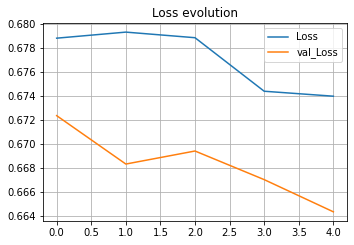

In [61]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')


Text(0.5, 1.0, 'Accuracy evolution')

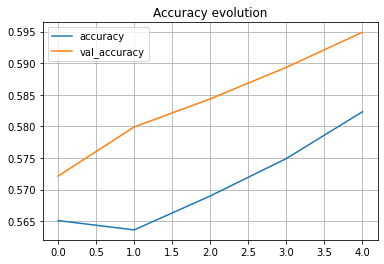

In [62]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

## **Bi-Directional LSTM**

In [64]:

model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))

#model.add(Dropout(0.25))
#model.add(Conv1D(128, 3, activation='relu'))
model.add(Bidirectional(LSTM(100, dropout=0.3)))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
#ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss',verbose = 1)
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
43/43 [==============================] - 7s 33ms/step - loss: 0.6827 - accuracy: 0.5564 - val_loss: 0.6594 - val_accuracy: 0.5938
Epoch 2/10
43/43 [==============================] - 1s 15ms/step - loss: 0.6641 - accuracy: 0.5988 - val_loss: 0.6409 - val_accuracy: 0.6226
Epoch 3/10
43/43 [==============================] - 1s 14ms/step - loss: 0.6382 - accuracy: 0.6308 - val_loss: 0.5884 - val_accuracy: 0.6709
Epoch 4/10
43/43 [==============================] - 1s 15ms/step - loss: 0.5958 - accuracy: 0.6811 - val_loss: 0.5794 - val_accuracy: 0.6926
Epoch 5/10
43/43 [==============================] - 1s 15ms/step - loss: 0.5629 - accuracy: 0.7112 - val_loss: 0.5489 - val_accuracy: 0.7148
Epoch 6/10
43/43 [==============================] - 1s 14ms/step - loss: 0.5367 - accuracy: 0.7268 - val_loss: 0.5573 - val_accuracy: 0.7125
Epoch 7/10
43/43 [==============================] - 1s 14ms/step - loss: 0.5165 - accuracy: 0.7399 - val_loss: 0.5334 - val_accuracy: 0.7392
Epoch 8/10
43

for later use
model.add(Embedding(input_dim=31308,
                    output_dim=embedding_size,
                    weights=[m],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

In [65]:
model.layers[0].trainable=True
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 66, 100)           1866400   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 512)               102912    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,130,625
Trainable params: 2,130,625
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
43/43 [==============================] - 1s 17ms/step - loss: 0.4708 - accuracy: 0.7769 - val_loss: 0.5627 - val_accuracy: 0.7392
Epoch 2/10
43/43 [==============================] - 1s 14ms/step - loss: 0.4597 - accuracy: 0.7802 - val_loss: 0.5436 - val_accuracy: 0.7436
Epoch 3/10
43/43 [==============================] - 1s 14ms/step - loss: 0.4616 - accuracy: 0.7775 - val_loss: 0.5663 - val_accuracy: 0.7342
Epoch 4/10
43/43 [==============================] - 1s 15ms/step - loss: 0.4387 - accuracy: 0.7984 - val_loss: 0.5780 - val_accuracy: 0.7336
Epoch 5/10
43/43 [==============================] - 1s 15ms/step - loss: 0.4447 - accuracy: 0.7974 - val_loss: 0.5718 - val_accuracy: 0.7358
Epoch 6/10
43/43 [==============================] - 1s 14ms/step - loss: 0.4338 - accuracy: 0.7956 - val_loss: 0.5490 - val_accuracy: 0.7397
Epoch 7/10
43/43 [==============================] - 1s 15ms/step - loss: 0.4187 - accuracy: 0.8065 - val_loss: 0.5647 - val_accuracy: 0.7436
Epoch 8/10
43

In [67]:

scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.753607103218646

In [68]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       833
           1       0.75      0.81      0.78       969

    accuracy                           0.75      1802
   macro avg       0.75      0.75      0.75      1802
weighted avg       0.75      0.75      0.75      1802



In [69]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[572 261]
 [183 786]]


Text(0.5, 1.0, 'Loss evolution')

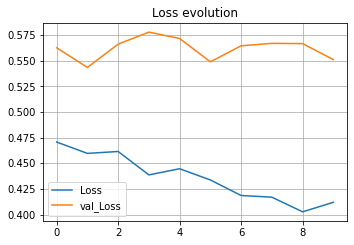

In [70]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

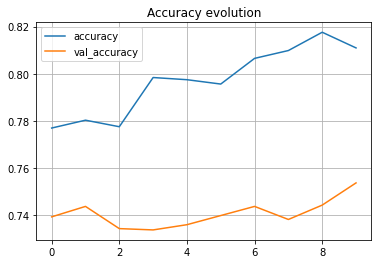

In [71]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')